<a href="https://colab.research.google.com/github/ihagoSantos/recommendation-systems/blob/main/recommendation_systems_evaluation_metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementação

Objetivos do notebook
- Implementar as métricas de acurácia: Hit Rate
- Implementar as métricas clássicas de decisão: Precision e Recall
- Implementar uma métrica de Ranking: MRR

In [2]:
# import libs
import operator
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.sparse import csr_matrix
from collections import OrderedDict

# useful command
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

plt.rcParams.update({'font.size': 14})

### Readint train and test files


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
base_url='/content/drive/My Drive/Pós Graduação PUC Minas/11 - Sistemas de Recomendação/Unidade 1/praticas/dataset/ML-1M'

df_train = pd.read_csv(
    base_url + '/trainSet.txt',
    sep='::',
    engine='python',
    names=['userId', 'itemId', 'rating', 'timestamp']
)
df_test = pd.read_csv(
    base_url + '/testSet.txt',
    sep='::',
    engine='python',
    names=['userId', 'itemId', 'rating', 'timestamp']
)

df_train.head()
df_test.head()

,userId,itemId,rating,timestamp
0,1,1193,5.0,978300760.0
1,1,661,3.0,978302109.0
2,1,914,3.0,978301968.0
3,1,3408,4.0,978300275.0
4,1,1197,3.0,978302268.0


,userId,itemId,rating,timestamp
0,1,2355,5.0,978824291.0
1,1,595,5.0,978824268.0
2,1,2687,3.0,978824268.0
3,1,48,5.0,978824351.0
4,1,745,3.0,978824268.0


## Creating Sparse Matrix for these sets

In [5]:
# sparse matrix of train set
users = df_train['userId']
items = df_train['itemId']
ratings = df_train['rating']

In [6]:
nb_users = max(users)
nb_items = max(items)

In [7]:
train_matrix = csr_matrix((ratings, (users, items)), shape=(nb_users + 1, nb_items + 1))
train_matrix.shape

(6041, 3953)

In [10]:
# Sparse matrix of test set
users = df_test['userId']
items = df_test['itemId']
ratings = df_test['rating']

test_matrix = csr_matrix((ratings, (users, items)), shape=(nb_users + 1, nb_items + 1))
test_matrix.shape

(6041, 3953)

## Reading the recommendation

In [11]:
def readRecommendation(file_name):
  recommendations = {}
  file_in = open(file_name, 'r')

  for row in file_in:
    row = row.rstrip()
    #extracting userId
    values = row.split('\t')
    userId = int(values[0])
    recommendations[userId] = []
    # extracting items
    values[1] = values[1].replace('[', '')
    values[1] = values[1].replace(']', '')
    recList = values[1].split(',')
    #saving items
    for tupla in recList:
      v = tupla.split(':')
      recommendations[userId].append(int(v[0]))

  file_in.close()

  return recommendations

reading all files saved before

In [13]:
base_url='/content/drive/My Drive/Pós Graduação PUC Minas/11 - Sistemas de Recomendação/Unidade 4/praticas'
rec_MostPopular = readRecommendation(base_url + '/recList_MostPopular.txt')
rec_BestRated = readRecommendation(base_url + '/recList_BestRated.txt')
rec_Rocchio = readRecommendation(base_url + '/recList_Rocchio.txt')
rec_PureSVD = readRecommendation(base_url + '/recList_PureSVD.txt')

In [14]:
rec_MostPopular[1]

[2858, 1196, 1210, 480, 589, 2571, 1198, 593, 1580, 110]

## Taxa de Acerto (Hit Rate)
É a média do número de itens recomendados que estão no conjunto teste de cada usuário
- Cada usuário tem uma lista de recomendação R associada
- Para cada usuário, conte quantos itens estão em R e no conjunto teste
- Calcule a média (i.e., some tudo e divida pelo número de usuários)
- Quanto maior o valor, melhor é o recomendador!

In [16]:
def metric_hitRate(users_targets, test_matrix, recommendation):
  hitRate = {}

  for u in users_targets:
    # items consumed by u in test set
    items_consumed = list(np.nonzero(test_matrix[u,:])[1])
    # hits represented by intersection
    hits = set(recommendation[u]).intersection(set(items_consumed))
    #saving
    hitRate[u] = len(hits)

  return hitRate

## Precision & Recall
### Precision
- Porcentagem de itens retornados que são relevantes
$$
Prec = \frac{|G \cap U|}{|R|}
$$
### Recall
- Porcentagem de itens relevantes que são retornados
$$
Rec = \frac{|G \cap R|}{|G|}
$$
Onde:
- G: relevant
- R: retrieved

In [27]:
def metric_precision_recall(users_targets, test_matrix, recommendation):
  precision = {}
  recall = {}

  for u in users_targets:
    # items consumed by u in test set
    items_consumed = list(np.nonzero(test_matrix[u,:])[1])
    # measuring u's avarage rating
    mean_rating = np.sum(test_matrix[u,:]) / float(len(items_consumed))
    # selecting relevant items for u
    relevants = []
    for i in items_consumed:
      if(test_matrix[u,i] >= mean_rating):
        relevants.append(i)

    # relevants INT retrieved
    inter = set(recommendation[u]).intersection(set(relevants))
    # measuring precision
    precision[u] = len(inter)/float(len(recommendation[u]))
    # measuring recall
    recall[u] = len(inter)/float(len(relevants))

  return precision, recall

## MRR: Mean Reciprocal Rank
- Similar ao Precision e Recall
  - Prec/Rec mensuram a probabilidade dos itens serem relevantes (precision) e do usuário encontrá-los (recall)
  - RR mensura o 'esforço' do usuário para encontrar os relevantes
- RR = 1/i, onde i é a posição do primeiro item relevante
- MRR: média desse esforço para os usuários
$$
\frac{1}{m}\sum_{i=1}^{m}RR(q_{i})
$$

In [18]:
def metric_reciprocalRank(users_targets, test_matrix, recommendation):
  reciprocalRank = {}
  for u in users_targets:
    # items consumed by u in test set
    items_consumed = list(np.nonzero(test_matrix[u,:])[1])
    # measuring u's avarage rating
    mean_rating = np.sum(test_matrix[u,:])/float(len(items_consumed))
    # selecting relevant items for u
    relevants = []
    for i in items_consumed:
      if(test_matrix[u,i] >= mean_rating):
        relevants.append(i)
    # measuring RR
    reciprocalRank[u] = 0
    cont = 1
    for i in recommendation[u]:
      if(i in relevants):
        reciprocalRank[u] = 1/float(cont)
        break
      else:
        cont += 1

  return reciprocalRank

# Analyzing recommendation effectiveness

In [19]:
users_targets = rec_MostPopular.keys()

In [20]:
def statisticInformation(distribution, name):
  print("RS:", name)
  print('\t- Min:', np.min(distribution))
  print('\t- Max:', np.max(distribution))
  print('\t- Mean:', np.mean(distribution))
  print('\t- Median:', np.median(distribution))
  print('\t- STD:', np.std(distribution))

In [21]:
def plotDistribution(distribution, x_label, y_label, name):
  distribution.sort(reverse=True)
  plt.plot(distribution, color='blue')
  plt.title(name)
  plt.ylabel(y_label)
  plt.xlabel(x_label)
  plt.show()

## Measuring hit-rate and analyzing it

In [22]:
hitRate_MP = metric_hitRate(users_targets, test_matrix, rec_MostPopular)
hitRate_BR = metric_hitRate(users_targets, test_matrix, rec_BestRated)
hitRate_Roc = metric_hitRate(users_targets, test_matrix, rec_Rocchio)
hitRate_SVD = metric_hitRate(users_targets, test_matrix, rec_PureSVD)

In [23]:
statisticInformation(list(hitRate_MP.values()), "Most-Popular")
statisticInformation(list(hitRate_BR.values()), "Best-Rated")
statisticInformation(list(hitRate_Roc.values()), "Rocchio")
statisticInformation(list(hitRate_SVD.values()), "PureSVD")

RS: Most-Popular
	- Min: 0
	- Max: 10
	- Mean: 1.054139072847682
	- Median: 0.0
	- STD: 1.600253318273547
RS: Best-Rated
	- Min: 0
	- Max: 10
	- Mean: 1.0440397350993378
	- Median: 0.0
	- STD: 1.631046338201806
RS: Rocchio
	- Min: 0
	- Max: 9
	- Mean: 0.2685430463576159
	- Median: 0.0
	- STD: 0.6718590373194409
RS: PureSVD
	- Min: 0
	- Max: 10
	- Mean: 1.2849337748344372
	- Median: 1.0
	- STD: 1.6844943909761534


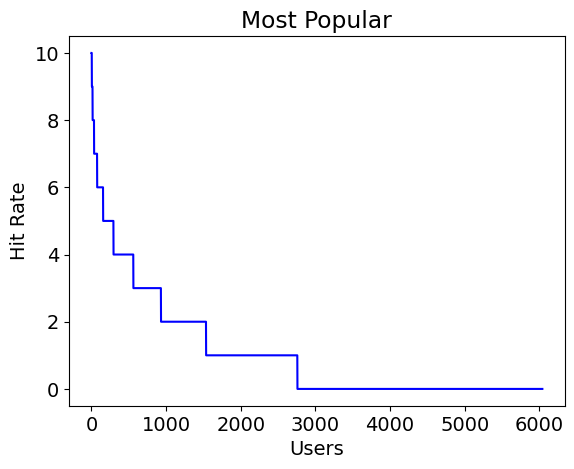

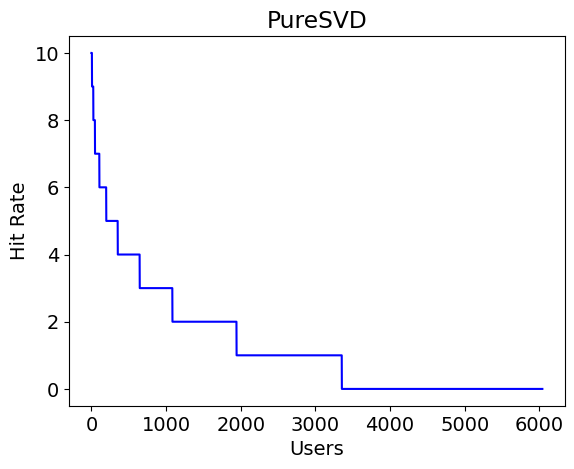

In [25]:
plotDistribution(list(hitRate_MP.values()), 'Users', 'Hit Rate', 'Most Popular')
# plotDistribution(list(hitRate_BR.values()), 'Users', 'Hit Rate', 'Best-Rated')
# plotDistribution(list(hitRate_Roc.values()), 'Users', 'Hit Rate', 'Rocchio')
plotDistribution(list(hitRate_SVD.values()), 'Users', 'Hit Rate', 'PureSVD')

## Measuring precision and recall and analyzing it

In [28]:
precision_MP, recall_MP = metric_precision_recall(users_targets, test_matrix, rec_MostPopular)
precision_BR, recall_BR = metric_precision_recall(users_targets, test_matrix, rec_BestRated)
precision_Roc, recall_Roc = metric_precision_recall(users_targets, test_matrix, rec_Rocchio)
precision_SVD, recall_SVD = metric_precision_recall(users_targets, test_matrix, rec_PureSVD)

Precision Analyzing

In [29]:
statisticInformation(list(precision_MP.values()), "Most-Popular")
statisticInformation(list(precision_BR.values()), "Best-Rated")
statisticInformation(list(precision_Roc.values()), "Rocchio")
statisticInformation(list(precision_SVD.values()), "PureSVD")

RS: Most-Popular
	- Min: 0.0
	- Max: 1.0
	- Mean: 0.0783112582781457
	- Median: 0.0
	- STD: 0.13272411686560392
RS: Best-Rated
	- Min: 0.0
	- Max: 1.0
	- Mean: 0.07960264900662252
	- Median: 0.0
	- STD: 0.13691676204206008
RS: Rocchio
	- Min: 0.0
	- Max: 0.5
	- Mean: 0.014619205298013247
	- Median: 0.0
	- STD: 0.04534475037006396
RS: PureSVD
	- Min: 0.0
	- Max: 1.0
	- Mean: 0.09827814569536424
	- Median: 0.0
	- STD: 0.14322566637703013


Recall Analyzing

In [30]:
statisticInformation(list(recall_MP.values()), "Most-Popular")
statisticInformation(list(recall_BR.values()), "Best-Rated")
statisticInformation(list(recall_Roc.values()), "Rocchio")
statisticInformation(list(recall_SVD.values()), "PureSVD")

RS: Most-Popular
	- Min: 0.0
	- Max: 1.0
	- Mean: 0.04995044597234478
	- Median: 0.0
	- STD: 0.09871510288985426
RS: Best-Rated
	- Min: 0.0
	- Max: 1.0
	- Mean: 0.05081093237477739
	- Median: 0.0
	- STD: 0.10232208900723808
RS: Rocchio
	- Min: 0.0
	- Max: 1.0
	- Mean: 0.013143848897088504
	- Median: 0.0
	- STD: 0.05526768364931675
RS: PureSVD
	- Min: 0.0
	- Max: 1.0
	- Mean: 0.07907353453517718
	- Median: 0.0
	- STD: 0.1348399727729013
